In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.debugger import set_trace
from importlib import reload
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append("/home/kim2712/Desktop/research/conformal_tree/")
sys.path.append("/home/kim2712/Desktop/research/generative_quantile/generative_qunatile/brenier/")
sys.path.append("/home/kim2712/Desktop/research/generative_quantile/generative_qunatile")

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
import argparse
import numpy as np
import scipy
from scipy.stats import norm
#our libs
import matplotlib.pyplot as plt
import seaborn as sns
import utils
from utils import truncated_normal
from gen_data import *
from torchvision import datasets, transforms, utils
from models import ConditionalConvexQuantile
from models import dual
DEVICE ="cpu"# torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.autograd.set_detect_anomaly(True)

In [4]:
from _utils.breiner_util import plot2d, histogram, plotaxis
from _data.synthetic import Synthetic

In [5]:
class args:
    device = "cuda"
    gauss=False
    batch_size = 128 
    epoch = 50 
    optimizer='adam'
    lr=0.005
    beta1 = 0.9 
    beta2=0.999
    nesterov=False
    iters=1000
    mean=0
    std=1    
    m=10
    n=5000
    k=100
    eps=0

In [6]:
print("Input arguments:")
for key, val in vars(args).items():
    print("{:16} {}".format(key, val))

Input arguments:
__module__       __main__
device           cuda
gauss            False
batch_size       128
epoch            50
optimizer        adam
lr               0.005
beta1            0.9
beta2            0.999
nesterov         False
iters            1000
mean             0
std              1
m                10
n                5000
k                100
eps              0
__dict__         <attribute '__dict__' of 'args' objects>
__weakref__      <attribute '__weakref__' of 'args' objects>
__doc__          None


In [7]:
def unif(size, eps=1E-7, device ="cuda"):
    return torch.clamp(torch.rand(size).to(device), min=eps, max=1-eps)

def train(net, optimizer, loader, args):
    k = args.k
    #eg = Rings() # EightGaussian()
    gauss = torch.distributions.normal.Normal(torch.tensor([0.]).to(args.device), 
                                              torch.tensor([1.]).to(args.device))
    for epoch in range(1, args.epoch+1):
        running_loss = 0.0
        for idx, (Y, label) in enumerate(loader):
            Y, label =Y.to(args.device),label.to(args.device)
            u = unif(size=(args.batch_size, 2), device=args.device)
            if args.gauss:
                u = gauss.icdf(u)
            optimizer.zero_grad()
            X,_ = net.to_onehot(label, 3)
            alpha, beta= net(u)
            loss = dual(U=u, Y_hat=(alpha, beta), Y=Y, X=X, eps=args.eps)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        if epoch % 10 == 0:
            print('%.5f' %
                (running_loss))#/(idx+1)))
            test(net, args,  loader)
            net.train()

    
def test(net, args, loader):
    net.eval()
    gauss = torch.distributions.normal.Normal(torch.tensor([0.]).to(args.device), 
                                              torch.tensor([1.]).to(args.device))
    U = unif(size=(5000, 2), device = args.device)
    if args.gauss:
        U = gauss.icdf(U)
    X = torch.zeros(5000, device=args.device).long()
    X[:5000//3] = 1
    X[5000//3: 10000//3] = 2
    #print(X)
    Y_hat,_ = net.grad(U, X)#= net.forward(U, grad=True).sum()
    #Y_hat = net.grad(U)
    print("max and min points generated: " + str(Y_hat.max()) + " " + str(Y_hat.min()))
    plot(Y_hat, X ,loader)
    
def plot(Y_hat,X, loader, s=3):
    fig, axis = plt.subplots(1,2)
    plot2d(Y_hat.detach().cpu(), 
           labels=X.cpu(), ax=axis[0],s=s)
    plot2d(loader.dataset.y, 
           labels=loader.dataset.x, ax=axis[1],s=s)
    fig.tight_layout()
    plt.show()

In [8]:
ds = Synthetic(args, n=args.n)
loader = data.DataLoader(ds, batch_size=args.batch_size, shuffle=True, drop_last=True)

596.36093
max and min points generated: tensor(18.3068, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-18.9169, device='cuda:0', grad_fn=<MinBackward1>)


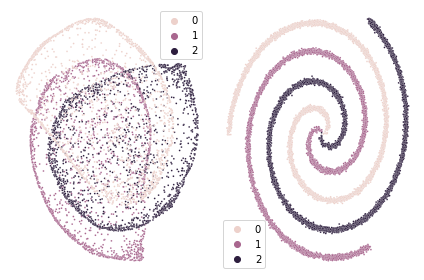

592.05721
max and min points generated: tensor(18.1496, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-18.0728, device='cuda:0', grad_fn=<MinBackward1>)


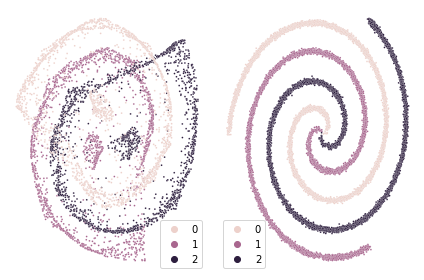

593.02872
max and min points generated: tensor(18.2574, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-19.6898, device='cuda:0', grad_fn=<MinBackward1>)


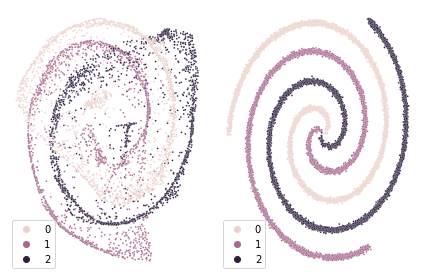

589.22305
max and min points generated: tensor(17.6210, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-19.1683, device='cuda:0', grad_fn=<MinBackward1>)


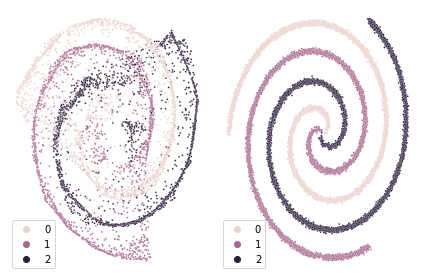

594.35197
max and min points generated: tensor(16.9538, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-19.5748, device='cuda:0', grad_fn=<MinBackward1>)


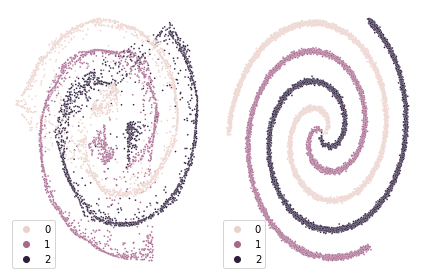

In [9]:
net = ConditionalConvexQuantile(xdim=3,ydim=2, 
                                a_hid=512,
                                a_layers=3,
                                b_hid=512,
                                b_layers=3)
optimizer = optim.Adam(net.parameters(), lr=args.lr, betas=(args.beta1, args.beta2))
net.to(args.device)
train(net, optimizer, loader, args)

1949.22637
max and min points generated: tensor(21.9138, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-23.3575, device='cuda:0', grad_fn=<MinBackward1>)


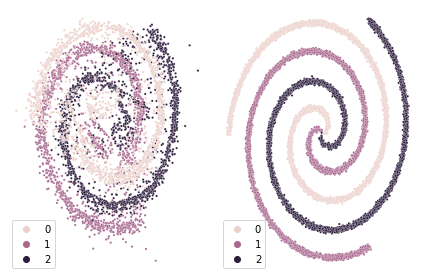

1949.12575
max and min points generated: tensor(20.6753, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-21.3544, device='cuda:0', grad_fn=<MinBackward1>)


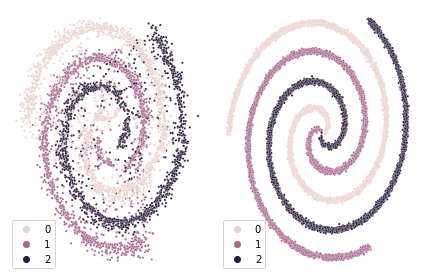

1943.18100
max and min points generated: tensor(18.1232, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-23.7291, device='cuda:0', grad_fn=<MinBackward1>)


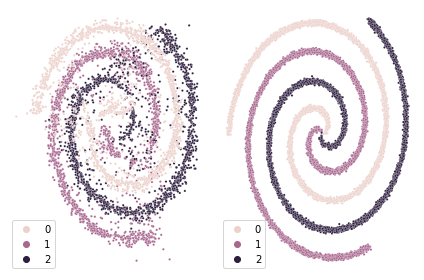

1947.48526
max and min points generated: tensor(17.9094, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-23.4685, device='cuda:0', grad_fn=<MinBackward1>)


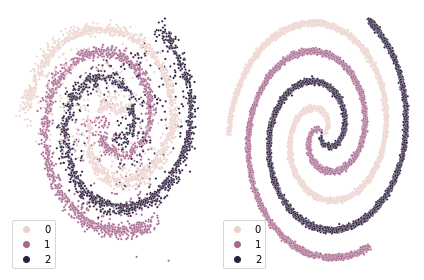

1939.11586
max and min points generated: tensor(17.8712, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-21.5412, device='cuda:0', grad_fn=<MinBackward1>)


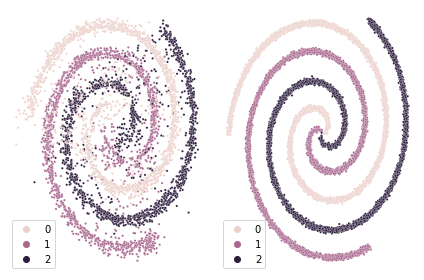

max and min points generated: tensor(17.9972, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-23.2027, device='cuda:0', grad_fn=<MinBackward1>)


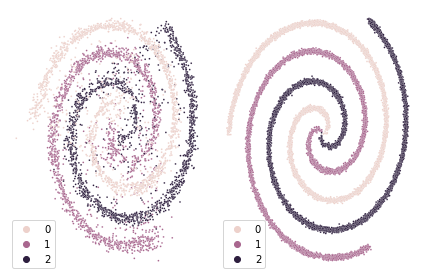

In [21]:
test(net, args, loader)

In [54]:
lstm = torch.nn.LSTM(30, 512, 1, batch_first=True, bidirectional=False)

In [53]:
for param in lstm.parameters():
    print(param.shape)


torch.Size([2048, 300])
torch.Size([2048, 512])
torch.Size([2048])
torch.Size([2048])
